In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load CSV
data = pd.read_csv('/content/marathi_pos_dataset_updated.csv')

# Handle non-string values safely before splitting
sentences = data['Original Sentence'].astype(str).apply(lambda x: x.strip().split()).tolist()
tags = data['POS Tags'].astype(str).apply(lambda x: x.strip().split()).tolist()

# Build vocabularies
words = set(w for sent in sentences for w in sent)
tags_set = set(t for ts in tags for t in ts)
word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1
tag2idx = {t: i+1 for i, t in enumerate(tags_set)}
tag2idx['PAD'] = 0
idx2tag = {i: t for t, i in tag2idx.items()}

MAX_LEN = 50
EMBED_DIM = 100
LSTM_UNITS = 64

# Encode and pad sequences
X = [[word2idx.get(w, 1) for w in s] for s in sentences]
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', value=0)
y = [[tag2idx[t] for t in ts] for ts in tags]
y = pad_sequences(y, maxlen=MAX_LEN, padding='post', value=0)
y = [to_categorical(seq, num_classes=len(tag2idx)) for seq in y]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2, random_state=42)

# Define the model with 3 unidirectional LSTM layers
model = Sequential()
model.add(Input(shape=(MAX_LEN,)))
model.add(Embedding(input_dim=len(word2idx), output_dim=EMBED_DIM))

# First LSTM layer with return_sequences=True
model.add(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Second LSTM layer
model.add(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Third LSTM layer
model.add(LSTM(units=LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

model.add(TimeDistributed(Dense(len(tag2idx), activation='softmax')))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.1, verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Prediction function
def predict_tags(sentence):
    seq = [word2idx.get(w, 1) for w in sentence]
    seq = pad_sequences([seq], maxlen=MAX_LEN, padding='post')
    pred = model.predict(seq)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred][:len(sentence)]
    return pred_tags

# Example usage:
example_sentence = ['मी', 'शाळेत', 'गेलो']
predicted_tags = predict_tags(example_sentence)
print("\nExample Sentence:", ' '.join(example_sentence))
print("Predicted POS Tags:", predicted_tags)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     2,271,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 122)        │         7,930 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,387,918 (9.11 MB)

 Trainable params: 2,387,918 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 134s 509ms/step - accuracy: 0.7128 - loss: 1.9723 - val_accuracy: 0.7899 - val_loss: 0.8713
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 135s 503ms/step - accuracy: 0.8013 - loss: 0.8149 - val_accuracy: 0.7934 - val_loss: 0.7961
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 138s 486ms/step - accuracy: 0.8071 - loss: 0.7476 - val_accuracy: 0.8019 - val_loss: 0.7484
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 143s 491ms/step - accuracy: 0.8189 - loss: 0.6844 - val_accuracy: 0.8065 - val_loss: 0.7178
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 141s 488ms/step - accuracy: 0.8264 - loss: 0.6445 - val_accuracy: 0.8127 - val_loss: 0.6963
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 139s 475ms/step - accuracy: 0.8326 - loss: 0.6072 - val_accuracy: 0.8163 - val_loss: 0.6788
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 143s 476ms/step - accuracy: 0.8370 - loss: 0.5741 - val_accuracy: 0.8219 - val_loss: 0.6540
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 143s 482ms/step - accuracy: 0.8444 -

Training Accuracy: 0.9339715242385864
Training Loss: 0.2199069857597351


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


Trial 10 Complete [00h 08m 07s]
val_accuracy: 0.8803271055221558

Best val_accuracy So Far: 0.8803271055221558
Total elapsed time: 01h 56m 49s

--- Hyperparameter Search Complete ---

The optimal number of LSTM layers is 2.
The optimal embedding dimension is 100.
The optimal learning rate for the optimizer is 0.01.


--- Training the Best Model Found by Tuner ---
Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 97s 361ms/step - accuracy: 0.7622 - loss: 1.0899 - val_accuracy: 0.8285 - val_loss: 0.6311
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 353ms/step - accuracy: 0.8476 - loss: 0.5568 - val_accuracy: 0.8622 - val_loss: 0.5099
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 141s 348ms/step - accuracy: 0.8832 - loss: 0.4217 - val_accuracy: 0.8735 - val_loss: 0.4796
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 143s 350ms/step - accuracy: 0.8968 - loss: 0.3623 - val_accuracy: 0.8771 - val_loss: 0.4789
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 143s 353ms/step - accuracy: 0.9041 - loss: 0.3352 - val_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     2,279,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 123)        │        11,931 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,485,239 (28.55 MB)

 Trainable params: 2,495,079 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,990,160 (19.04 MB)


--- Evaluating the Final Model ---
Test Loss: 0.4400
Test Accuracy: 0.8882


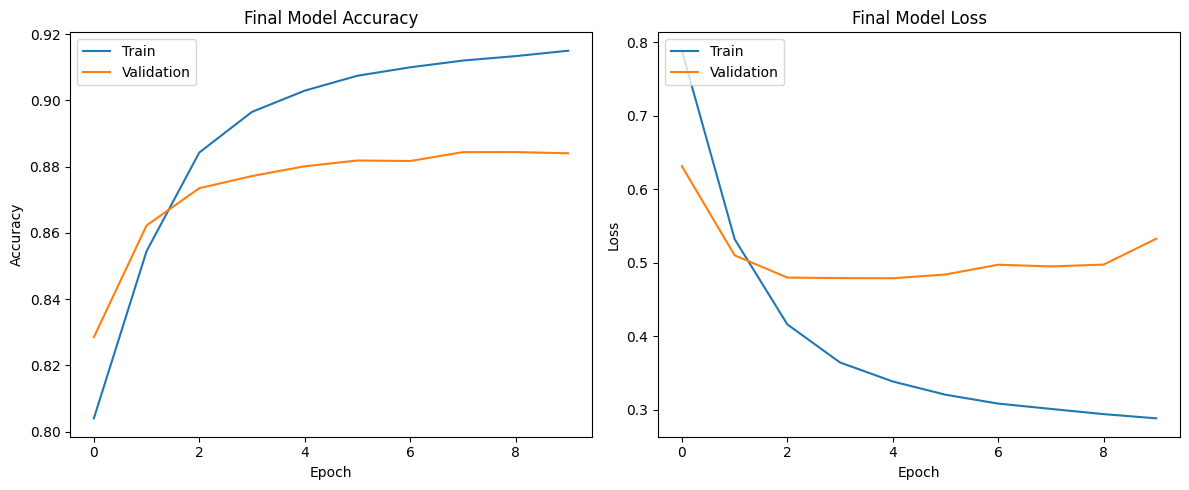

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- Prediction Example ---
Example Sentence: मी शाळेत गेलो
Predicted POS Tags: PRP NN VM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Example Sentence: तो एक चांगला मुलगा आहे
Predicted POS Tags: PRP QC JJ NN VAUX


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

# --- 1. Data Loading and Preprocessing ---
# Ensure you have the CSV file in the correct path
try:
    data = pd.read_csv('/content/marathi_pos_dataset_updated.csv')
except FileNotFoundError:
    print("Error: 'marathi_pos_dataset_updated.csv' not found.")
    print("Please make sure the dataset file is uploaded to the '/content/' directory.")
    # Create a dummy dataframe to avoid further errors
    data = pd.DataFrame({
        'Original Sentence': ['मी शाळेत गेलो', 'ती घरी आली'],
        'POS Tags': ['PRON NOUN VERB', 'PRON NOUN VERB']
    })


# Handle non-string values safely before splitting
sentences = data['Original Sentence'].astype(str).apply(lambda x: x.strip().split()).tolist()
tags = data['POS Tags'].astype(str).apply(lambda x: x.strip().split()).tolist()

# Build vocabularies
words = set(w for sent in sentences for w in sent)
tags_set = set(t for ts in tags for t in ts)

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx['PAD'] = 0  # Padding
word2idx['UNK'] = 1  # Unknown words

tag2idx = {t: i + 1 for i, t in enumerate(tags_set)}
tag2idx['PAD'] = 0   # Padding for tags

idx2tag = {i: t for t, i in tag2idx.items()}

# Constants
MAX_LEN = 50
VOCAB_SIZE = len(word2idx)
TAG_COUNT = len(tag2idx)

# Encode and pad sequences
X = [[word2idx.get(w, 1) for w in s] for s in sentences]
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', value=word2idx['PAD'])

y = [[tag2idx.get(t, 0) for t in ts] for ts in tags]
y = pad_sequences(y, maxlen=MAX_LEN, padding='post', value=tag2idx['PAD'])
y = [to_categorical(seq, num_classes=TAG_COUNT) for seq in y]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2, random_state=42)

# --- 2. Model Builder for KerasTuner ---
def build_model(hp):
    """
    Builds a sequential model and defines the hyperparameter search space.
    Args:
        hp: KerasTuner HyperParameters object.
    Returns:
        A compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=(MAX_LEN,)))

    # Tune the embedding dimension
    hp_embed_dim = hp.Int('embed_dim', min_value=50, max_value=200, step=50)
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=hp_embed_dim, input_length=MAX_LEN))

    # Tune the number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        # Tune LSTM units and dropout rate for each layer
        hp_lstm_units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32)
        hp_dropout = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(LSTM(
            units=hp_lstm_units,
            return_sequences=True,
            dropout=hp_dropout,
            recurrent_dropout=hp_dropout
        ))

    # Output layer
    model.add(TimeDistributed(Dense(TAG_COUNT, activation='softmax')))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 3. Hyperparameter Tuning with RandomSearch ---
# You can also use kt.Hyperband for a more advanced tuning algorithm
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1, # Number of models to train for each trial
    directory='pos_tuning_dir',
    project_name='marathi_pos_tagger'
)

print("\n--- Starting Hyperparameter Search ---")
# Use a smaller subset and fewer epochs for a faster search
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)
print("\n--- Hyperparameter Search Complete ---")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of LSTM layers is {best_hps.get('num_lstm_layers')}.
The optimal embedding dimension is {best_hps.get('embed_dim')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# --- 4. Train the Best Model ---
print("\n--- Training the Best Model Found by Tuner ---")
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=30,  # Train for more epochs with the best model
    batch_size=32,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.summary()

# --- 5. Evaluate and Visualize ---
print("\n--- Evaluating the Final Model ---")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# --- 6. Prediction Function ---
def predict_tags(sentence_list):
    """Predicts POS tags for a given sentence (list of words)."""
    seq = [word2idx.get(w, 1) for w in sentence_list] # Use 1 for 'UNK'
    padded_seq = pad_sequences([seq], maxlen=MAX_LEN, padding='post', value=word2idx['PAD'])
    pred_probs = model.predict(padded_seq)[0]
    pred_indices = np.argmax(pred_probs, axis=-1)
    pred_tags = [idx2tag.get(i, 'PAD') for i in pred_indices][:len(sentence_list)]
    return pred_tags

# Example usage:
example_sentence = ['मी', 'शाळेत', 'गेलो']
predicted_tags = predict_tags(example_sentence)
print("\n--- Prediction Example ---")
print("Example Sentence:", ' '.join(example_sentence))
print("Predicted POS Tags:", ' '.join(predicted_tags))

example_sentence_2 = ['तो', 'एक', 'चांगला', 'मुलगा', 'आहे']
predicted_tags_2 = predict_tags(example_sentence_2)
print("\nExample Sentence:", ' '.join(example_sentence_2))
print("Predicted POS Tags:", ' '.join(predicted_tags_2))